In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import pickle
import numpy as np

# Load the pickle files we created in our load_images_notebook file
X_f = pickle.load(open("X_features.pickle", "rb"))
y_l = pickle.load(open("y_labels.pickle", "rb"))
y_l[12] = 1
# Normalize the data
X_f = tf.keras.utils.normalize(X_f, axis=1)

# # Construct the model
model = Sequential()

#Conv2D: Start with a convolutional layer
#3x3 window
model.add(Conv2D(64, (3,3), input_shape = X_f.shape[1:])) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
# Now we do it all again!
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# For good measure, put the data through a final dense layer at the end
# Need to flatten the data from its 2D form for convolutional to 1D form
# for the dense layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(.5))
# Final output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))
# In this instance we will use binary crossentropy since it is Clean vs. Contaminated
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.25,
                              patience=5, min_lr=0.001)
model.fit(X_f, y_l, batch_size=32, validation_split=0.25, epochs=40, callbacks=[reduce_lr])


Train on 78 samples, validate on 27 samples
Epoch 1/40
78/78 [==============================] - 1s 15ms/sample - loss: 1.3167 - acc: 0.5128 - val_loss: 0.7205 - val_acc: 0.4815
Epoch 2/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.7107 - acc: 0.4615 - val_loss: 0.6916 - val_acc: 0.5185
Epoch 3/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.6779 - acc: 0.5513 - val_loss: 0.7002 - val_acc: 0.5185
Epoch 4/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.7019 - acc: 0.5385 - val_loss: 0.6805 - val_acc: 0.5185
Epoch 5/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.6628 - acc: 0.5897 - val_loss: 0.6709 - val_acc: 0.5185
Epoch 6/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.6652 - acc: 0.6282 - val_loss: 0.6624 - val_acc: 0.5185
Epoch 7/40
78/78 [==============================] - 1s 8ms/sample - loss: 0.6552 - acc: 0.5641 - val_loss: 0.6391 - val_acc: 0.5556
Epoch 8/40
78/78 [=============

In [31]:
# Save the model
# model.save("basic_binary_CNN.model")
# tf.keras.models.save_model(model, "aquasight_binary_CNN.h5")

# # Convert to TFLite model
# converter = tf.lite.TFLiteConverter.from_keras_model_file("aquasight_binary_CNN.h5")
# tflite_model = converter.convert()
# open("converted_CNN.tflite", "wb").write(tflite_model)

In [32]:
# https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras?answertab=votes#tab-top
import tensorflow.keras.backend as K
# uncertaintyFunction = K.function([model.layers[0].input, K.learning_phase()],
#                [model.layers[-1].output])

# def predict_with_uncertainty(f, x, n_iter=91):
#     result = []
#     for i in range(n_iter):
#         result.append(f([x, 1]))
    
#     result = numpy.array(result)

#     prediction = result.mean(axis=0)
#     uncertainty = result.var(axis=0)
#     return prediction, uncertainty
# prediction, uncertainty = predict_with_uncertainty(uncertaintyFunction, X_f)
# print(prediction)

105/105 [==============================] - 0s 4ms/sample - loss: 0.1077 - acc: 0.9619
0.1076807955900828 0.96190476
[0.9972812]


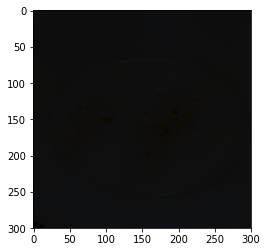

In [35]:
# # new_model = tf.keras.models.load_model('E:/Users/Elliott/dev/aquavision_project/basic_binary_classifier.model')
val_loss, val_acc = model.evaluate(X_f, y_l)
print(val_loss, val_acc)

# Predict wants a numpy array as its parameter
predictions = model.predict(X_f)

In [36]:
# tf.keras.models.save_model(model, "model_2.0_includes_new_data.model")

In [37]:
test_new_model = tf.keras.models.load_model("model_2.0_includes_new_data.model")
test_new_model.evaluate(X_f, y_l)

105/105 [==============================] - 1s 5ms/sample - loss: 0.1077 - acc: 0.9619


[0.1076807955900828, 0.96190476]

In [38]:
import matplotlib.pyplot as plt
predictions = test_new_model.predict(X_f)
k = 0
print("The prediction for the image at index {} is: {}".format(k, np.rint(predictions[k])))
print("The correct value for the image at index {} is: {}".format(k, y_l[k]))

numCorr = 0
for k in range(0, len(predictions)):
    if(np.rint(predictions[k]) == y_l[k]):
        numCorr+=1
    else:
        print("Missed image at index: {}".format(k))
        print("Prediction for image was {}".format(predictions[k]))
        print("Correct value for image was {} --> {}\n".format(y_l[k], "Clean" if y_l[k] == 0 else "Contaminated"))
        
#         Print nums of images we didn't get
#         Indexes 68 and 78 (#69 and 79) are consistently missed
#         Index 6 (#7) also causes problems.
#         Indexes 67, 75 not recognized properly - 7:17 PM April 13, 2019
#         Indexes 2,12,23,77,93,98 - 9:18 PM April 13, 2019
#         Consistently missing 93 and 98 from the new images, as well as having issues with 2 and 12
print("numCorr: {}".format(numCorr))
print("Accuracy is: {}".format(numCorr/len(predictions)))

The prediction for the image at index 0 is: [0.]
The correct value for the image at index 0 is: 0
Missed image at index: 2
Prediction for image was [0.8258327]
Correct value for image was 0 --> Clean

Missed image at index: 77
Prediction for image was [0.71018493]
Correct value for image was 0 --> Clean

Missed image at index: 93
Prediction for image was [0.45486015]
Correct value for image was 1 --> Contaminated

Missed image at index: 98
Prediction for image was [0.8942989]
Correct value for image was 0 --> Clean

numCorr: 101
Accuracy is: 0.9619047619047619


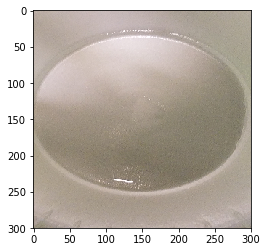

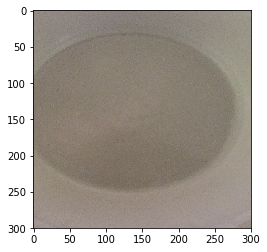

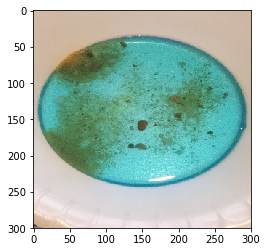

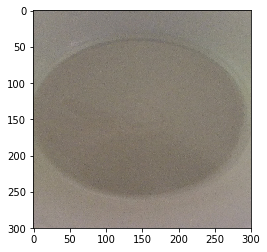

In [42]:
X_f = pickle.load(open("X_features.pickle", "rb"))
plt.imshow(X_f[2])
plt.show()
plt.imshow(X_f[77])
plt.show()
plt.imshow(X_f[93])
plt.show()
plt.imshow(X_f[98])
plt.show()

In [40]:

# Calculate average confidence in a prediction
numClean = 0
numContam = 0
totCl = 0 
totCo = 0
for pred in predictions:
    if pred < .5:
        numClean+=1
        totCl+=pred
    else:
        numContam+=1
        totCo+=pred
print("Average value of clean predictions: {}".format(totCl/numClean))
print("Average value of contaminated predictions: {}".format(totCo/numContam))

Average value of clean predictions: [0.08088741]
Average value of contaminated predictions: [0.96408075]


In [41]:
cleanPreds = []
contPreds = []
for pred in predictions:
    if pred < .5:
        cleanPreds.append(pred)
    else:
        contPreds.append(pred)
print("Max: {} and Min: {} of clean".format(max(cleanPreds), min(cleanPreds)))
print("Max: {} and Min: {} of clean".format(max(contPreds), min(contPreds)))

Max: [0.46283793] and Min: [0.00187266] of clean
Max: [0.99999684] and Min: [0.71018493] of clean
